![BTS](https://github.com/vfp1/bts-mbds-data-science-foundations-2019/raw/master/sessions/img/Logo-BTS.jpg)

# Session 14: Model validation cted. and algorithms
### Victor F. Pajuelo Madrigal <victor.pajuelo@bts.tech> - Data Science Foundations (2019-11-28)

Open this notebook in Google Colaboratory: [![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/vfp1/bts-mbds-data-science-foundations-2019/blob/master/sessions/14_Data_splits_CV_and_probability_curves.ipynb)

**Resources:**

*   Jake VanderPlass
*   Machine Learning Mastery
*   Sklearn documentation



# About the next sessions

*   Model validation
*   In depth algorithms
*   Data scrapping, gathering
*   Project to product: Docker and app release

# Data splits

*The literature on machine learning often reverses the meaning of “validation” and “test” sets. This is the most blatant example of the terminological confusion that pervades artificial intelligence research.*

*The crucial point is that a test set, by the standard definition in the NN [neural net] literature, is never used to choose among two or more networks, so that the error on the test set provides an unbiased estimate of the generalization error (assuming that the test set is representative of the population, etc.).*


* **Training Dataset**: The sample of data used to fit the model.
* **Validation Dataset**: The sample of data used to provide an unbiased evaluation of a model fit on the training dataset while tuning model hyperparameters. The evaluation becomes more biased as skill on the validation dataset is incorporated into the model configuration.
* **Test Dataset**: The sample of data used to provide an unbiased evaluation of a final model fit on the training dataset.

We can make this concrete with a pseudocode sketch:


In [0]:
# split data
data = ...
train, validation, test = split(data)
 
# tune model hyperparameters
parameters = ...
for params in parameters:
	model = fit(train, params)
	skill = evaluate(model, validation)
 
# evaluate final model for comparison with other models
model = fit(train)
skill = evaluate(model, test)

## Important note on jargon!!!

* **Model evaluation** is done with the `test split`
* **Model validation** is done with the `validation split` (extracted from train)
* **Model training** is done with the training split

## Computing a Train, Validation, Test split in Sklearn

Here the train is 60%, the validation is 20% and the test is 20% over the whole dataset



In [0]:
from sklearn.model_selection import train_test_split

 X_train, X_test, y_train, y_test 
    = train_test_split(X, y, test_size=0.2, random_state=1)

 X_train, X_val, y_train, y_val 
    = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

## Computing a Train, Validation, Test split in Keras

In Keras is slightly easier to compute a validation split, you just pass it to the *fit* function. 

If you set the validation_split argument in model.fit to e.g. 0.1, then the validation data used will be the last 10% of the data. If you set it to 0.25, it will be the last 25% of the data, etc. Note that the data isn't shuffled before extracting the validation split, so the validation is literally just the last x% of samples in the input you passed.

The same validation set is used for all epochs (within a same call to fit).

In [0]:
hist = model.fit(x_train, y_train, validation_split=0.2)

## Your turn

Perform a TVT split over the dataset chosen for your project. Print the shape of each subset. If you do not have a dataset yet, chose iris dataset from sklearn.

# Cross-validation again

## Evaluating estimator performance

Learning the parameters of a prediction function and testing it on the same data is a methodological mistake: `a model that would just repeat the labels of the samples that it has just seen would have a perfect score but would fail to predict anything useful on yet-unseen data`. This situation is called **overfitting**. To avoid it, it is common practice when performing a `(supervised) machine learning` experiment to hold out part of the available data as a test set `X_test, y_test`. 

Here is a flowchart of typical cross validation workflow in model training. The best parameters can be determined by `grid search` techniques.

![alt text](https://scikit-learn.org/stable/_images/grid_search_workflow.png)

In [0]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm

iris = datasets.load_iris()
iris.data.shape, iris.target.shape

((150, 4), (150,))

We can now quickly sample a training set while holding out 40% of the data for testing (evaluating) our classifier:



In [0]:
X_train, X_test, \
y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.4, random_state=0)

In [0]:
X_train.shape, y_train.shape

((90, 4), (90,))

In [0]:
X_test.shape, y_test.shape

((60, 4), (60,))

In [0]:
clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)

In [0]:
clf.score(X_test, y_test)                           

0.9666666666666667

### The problem of under or overfitting: tuning model hyperparameters

When evaluating different settings (“hyperparameters”) for estimators, such as the C setting that must be manually set for an SVM, there is still a **risk of overfitting on the test set** because the `parameters can be tweaked until the estimator performs optimally`. This way, `knowledge about the test set can “leak”` into the model and evaluation metrics no longer report on generalization performance. 

To solve this problem, `yet another part of the dataset can be held out as a so-called “validation set”`: training proceeds on the training set, after which evaluation is done on the validation set, and when the experiment seems to be successful, final evaluation can be done on the test set.

However, by partitioning the available data into three sets, we drastically reduce the number of samples which can be used for learning the model, and the results can depend on a particular random choice for the pair of (train, validation) sets.

A solution to this problem is a procedure called `cross-validation (CV for short)`. A test set should still be held out for final evaluation, but **the validation set is no longer needed** when doing CV. In the basic approach, called k-fold CV, the training set is split into k smaller sets. There are other approaches that we will learn later in the course.

**Key takeaways**

* When we train our algorithm, we get a score at the end.
* We can modify the hyperparameters for our training in order to improve that score
* That results in the fact that we are "tuning" the model based on the results on the test, thus leaking the test into the training and halting generalization
* We could avoid this by using a validation set, to evaluate the model on training. However, this will reduce severly our dataset
* We can use CV for maintaining the size of our dataset while using parts of it for evaluation

The following procedure is followed for each of the k “folds”:

*  A model is trained using `k-1` of the folds as training data
*  The resulting model is evaluated on the remaining part of the data (i.e., it is used as a test set to compute a performance measure such as accuracy).

The performance measure reported by k-fold cross-validation is then the average of the values computed in the loop. **This approach can be computationally expensive**, but does not waste too much data (as is the case when fixing an arbitrary validation set), which is a major advantage in problems when our data is too small.

![alt text](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)

### Computing cross-validation metrics

The simplest way to use cross-validation is to call the `cross_val_score` helper function on the estimator and the dataset.

The following example demonstrates how to estimate the accuracy of a linear kernel support vector machine on the iris dataset by splitting the data, fitting a model and computing the score 5 consecutive times (with different splits each time):

In [0]:
from sklearn.model_selection import cross_val_score
clf = svm.SVC(kernel='linear', C=1)
scores = cross_val_score(clf, iris.data, iris.target, cv=5)
scores                                              

array([0.96666667, 1.        , 0.96666667, 0.96666667, 1.        ])

The mean score and the 95% confidence interval of the score estimate are hence given by:



In [0]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.98 (+/- 0.03)


By default, the score computed at each CV iteration is the score method of the estimator. It is possible to change this by using the scoring parameter.

You can check the available scorings [here](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter).

In [0]:
from sklearn import metrics
scores = cross_val_score(clf, iris.data, iris.target, cv=5, scoring='f1_macro')
scores  

array([0.96658312, 1.        , 0.96658312, 0.96658312, 1.        ])

#### Tweaking n_jobs

Cross validation it is a heavy computing process, we can tweak the number of CPUs involved by using n_jobs (-1 uses all the available ones by default). Be careful, if your model is too big leave one CPU out so you can still watch videos on YouTube.

In [0]:
from sklearn import metrics
scores = cross_val_score(clf, iris.data, iris.target, cv=5, scoring='f1_macro', n_jobs=-1)
scores  

array([0.96658312, 1.        , 0.96658312, 0.96658312, 1.        ])

In the case of the Iris dataset, the samples are balanced across target classes hence the accuracy and the F1-score are almost equal.

When the `cv argument is an integer`, cross_val_score uses the `KFold` or StratifiedKFold strategies by default, the latter being used if the estimator derives from ClassifierMixin.

## Parameter estimation: GridSearch + Cross Validation

We can use GridSearch + CrossValidation to select our model parameters.

We use the dedicated function called GridSearchCV which can be used for that matter.

The performance of the selected hyper-parameters and trained model is then measured on a dedicated evaluation set that was not used during the model selection step.

In [0]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC

# Loading the Digits dataset
digits = datasets.load_digits()

# To apply an classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
n_samples = len(digits.images)
X = digits.images.reshape((n_samples, -1))
y = digits.target

print(X.shape, y.shape)

(1797, 64) (1797,)


In [0]:
# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=0)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(898, 64) (898,)
(899, 64) (899,)


In [0]:
# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

In [0]:
import sklearn
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'brier_score_loss',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'v_measure_score']

In [0]:
clf = GridSearchCV(SVC(), tuned_parameters, cv=5,
                    scoring='accuracy')
clf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid=[{'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000], 'kernel': ['linear']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [0]:
clf.best_params_

{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}

### Using more than one metric

In [0]:
# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

scores = ['accuracy','precision', 'recall']

In [0]:
for score in scores:
    print("-----------------------------------------")
    print("# Tuning hyper-parameters for %s" % score)
    print()

    if score == 'accuracy':

        clf = GridSearchCV(SVC(), tuned_parameters, cv=5,
                        scoring=score)
        clf.fit(X_train, y_train)

    else:

        clf = GridSearchCV(SVC(), tuned_parameters, cv=5,
                        scoring='%s_macro' % score)
        clf.fit(X_train, y_train)


    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']

    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

# Note the problem is too easy: the hyperparameter plateau is too flat and the
# output model is the same for precision and recall with ties in quality.

-----------------------------------------
# Tuning hyper-parameters for accuracy

Best parameters set found on development set:

{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}

Grid scores on development set:

0.986 (+/-0.021) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.958 (+/-0.029) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.987 (+/-0.021) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.981 (+/-0.029) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.987 (+/-0.021) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.981 (+/-0.027) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.987 (+/-0.021) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.981 (+/-0.027) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.973 (+/-0.015) for {'C': 1, 'kernel': 'linear'}
0.973 (+/-0.015) for {'C': 10, 'kernel': 'linear'}
0.973 (+/-0.015) for {'C': 100, 'kernel': 'linear'}
0.973 (+/-0.015) for {'C': 1000, 'kernel': 'linear'}

Detailed classification report:

The model is trained on the full d

## Your turn

Estimate the best parameters for your training, taking into account accuracy alone, for your dataset using Cross Validation.

If you are doing a classification problem, try precision and recall as well.

# Predicting probabilities: PR and ROC curves

When making a prediction for a binary or two-class classification problem, there are two types of errors that we could make.

* **False Positive**. Predict an event when there was no event.
* **False Negative**. Predict no event when in fact there was an event.

By predicting probabilities and calibrating a threshold, a balance of these two concerns can be chosen by the operator of the model.

**Precision** ($P$) is defined as the number of true positives ($T_p$) over the number of true positives plus the number of false positives ($F_p$).

$P = \frac{T_p}{T_p+F_p}$

**Recall or Sensitivity** ($R$) is defined as the number of true positives ($T_p$) over the number of true positives plus the number of false negatives ($F_n$).

$R = \frac{T_p}{T_p + F_n}$

These quantities are also related to the ($F_1$) score, which is defined as the **harmonic mean of precision and recall**.

$F1 = 2\frac{P \times R}{P+R}$




## ROC curves

A useful tool to predict probability of binary outcume (only binary!) is the Receiver Operating Characteristic cruve or ROC curve.

The ROC curve plots the **FALSE POSITIVE RATE** (x-axis) versus the **TRUE POSITIVE RATE** (y-axis). We know that the **TRUE POSITIVE RATE** is the Recall or Sensitivity, but what is the **FALSE POSITIVE RATE**?

$FPR = \frac{F_p}{F_p+T_n}$

It is a plot of the false positive rate (x-axis) versus the true positive rate (y-axis) for a number of different candidate threshold values between 0.0 and 1.0. Put another way, it plots the false alarm rate versus the hit rate.

* Smaller values on the x-axis of the plot indicate lower false positives and higher true negatives.
* Larger values on the y-axis of the plot indicate higher true positives and lower false negatives.

`If you are confused, remember, when we predict a binary outcome, it is either a correct prediction (true positive) or not (false positive). There is a tension between these options, the same with true negative and false negative.`

A skilful model will assign a higher probability to a randomly chosen real positive occurrence than a negative occurrence on average. This is what we mean when we say that the model has skill. Generally, skilful models are represented by curves that bow up to the top left of the plot.

A no-skill classifier is one that cannot discriminate between the classes and would predict a random class or a constant class in all cases. A model with no skill is represented at the point (0.5, 0.5). A model with no skill at each threshold is represented by a diagonal line from the bottom left of the plot to the top right and has an AUC of 0.5.

A model with perfect skill is represented at a point (0,1). A model with perfect skill is represented by a line that travels from the bottom left of the plot to the top left and then across the top to the top right.

An operator may plot the ROC curve for the final model and choose a threshold that gives a desirable balance between the false positives and false negatives.





No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.903


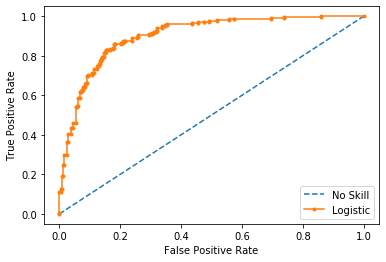

In [0]:
# roc curve and auc
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

# generate 2 class dataset
X, y = make_classification(n_samples=1000, n_classes=2, random_state=1)

# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2)

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(testy))]

# fit a model
model = LogisticRegression(solver='lbfgs')
model.fit(trainX, trainy)

# predict probabilities
lr_probs = model.predict_proba(testX)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# calculate scores
ns_auc = roc_auc_score(testy, ns_probs)
lr_auc = roc_auc_score(testy, lr_probs)

# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
#No skill model
ns_fpr, ns_tpr, thres_ns = roc_curve(testy, ns_probs)
# Logarithmic model
lr_fpr, lr_tpr, thres_lr = roc_curve(testy, lr_probs)

# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')

# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [0]:
thres_lr

array([1.99981055e+00, 9.99810555e-01, 9.92408365e-01, 9.91679828e-01,
       9.90144555e-01, 9.89867568e-01, 9.79265264e-01, 9.79115074e-01,
       9.61958719e-01, 9.61681033e-01, 9.47453942e-01, 9.46083338e-01,
       9.24765054e-01, 9.23985965e-01, 9.03776284e-01, 8.96563782e-01,
       8.88294853e-01, 8.87112806e-01, 8.78078335e-01, 8.76612424e-01,
       8.28429524e-01, 8.27959147e-01, 8.23317999e-01, 8.22322697e-01,
       8.07658186e-01, 8.07653554e-01, 7.79441385e-01, 7.68060225e-01,
       7.63062006e-01, 7.62912313e-01, 7.61564252e-01, 7.58648634e-01,
       7.49642618e-01, 7.46446600e-01, 7.32873897e-01, 7.31335000e-01,
       7.23434675e-01, 7.15862908e-01, 6.92545325e-01, 6.92512778e-01,
       6.92244651e-01, 6.82799726e-01, 6.80222962e-01, 6.79729854e-01,
       6.70153267e-01, 6.56639891e-01, 6.47658558e-01, 6.46419471e-01,
       6.36044813e-01, 6.35647643e-01, 6.18886716e-01, 6.14825818e-01,
       6.12198494e-01, 6.03026960e-01, 5.92619457e-01, 5.90439114e-01,
      

### Finding the best threshold: cutoff point

This depends on our classification problem!!!! If we are dealing with crimes (when people are dead) we want to maximize, TPR so that we avoid people dying. But in a non life threatening scenario, we can actually use this method.

In [0]:
import pandas as pd

def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value

    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 
                        'threshold' : pd.Series(threshold, index=i),
                        'tpr': pd.Series(tpr, index=i),
                        'fpr': pd.Series((fpr), index=i)})
    
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']), list(roc_t['tpr']), list(roc_t['fpr'])

Best threshold [0.529530623434401]
Best TPR [0.8346153846153846]
Best FPR [0.16666666666666666]


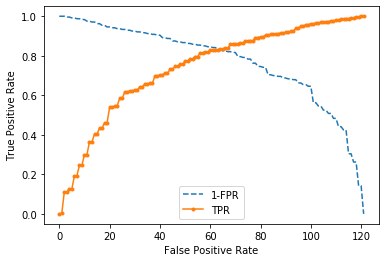

In [0]:
####################################
# The optimal cut off would be where tpr is high and fpr is low
# tpr - (1-fpr) is zero or near to zero is the optimal cut off point
####################################

a, b, c = Find_Optimal_Cutoff(testy, lr_probs)

print("Best threshold", a)
print("Best TPR", b)
print("Best FPR", c)

# plot the roc curve for the model
pyplot.plot(1-lr_fpr, linestyle='--', label='1-FPR')
pyplot.plot(lr_tpr, marker='.', label='TPR')

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')

# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [0]:
y_class = lr_probs > a
y_class

array([ True,  True, False, False,  True, False, False, False,  True,
        True, False,  True, False,  True,  True,  True, False,  True,
       False,  True,  True, False, False,  True, False,  True,  True,
        True, False,  True,  True,  True, False,  True, False, False,
        True,  True,  True, False, False, False, False,  True, False,
       False, False,  True, False, False, False,  True,  True, False,
       False,  True, False, False, False,  True,  True, False,  True,
       False, False, False, False, False,  True,  True, False, False,
        True,  True,  True,  True, False,  True, False, False, False,
       False,  True, False,  True, False,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True, False,
        True,  True, False,  True, False, False, False,  True, False,
        True, False, False,  True,  True, False, False,  True,  True,
       False, False,  True, False, False, False, False,  True,  True,
        True,  True,

## Precision-Recall curves

Precision-Recall is a useful measure of success of prediction when the classes are very imbalanced. In information retrieval, precision is a measure of result relevancy, while recall is a measure of how many truly relevant results are returned.

The precision-recall curve shows the tradeoff between precision and recall for different threshold. A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall).

A system with high recall but low precision returns many results, but most of its predicted labels are incorrect when compared to the training labels. A system with high precision but low recall is just the opposite, returning very few results, but most of its predicted labels are correct when compared to the training labels. An ideal system with high precision and high recall will return many results, with all results labeled correctly.

Note that the **precision may not decrease with recall**. The definition of precision ($\frac{T_p}{T_p + F_p}$) shows that lowering the threshold of a classifier may increase the denominator, by increasing the number of results returned. If the threshold was previously set too high, the new results may all be true positives, which will increase precision. If the previous threshold was about right or too low, further lowering the threshold will introduce false positives, decreasing precision.

Recall is defined as $\frac{T_p}{T_p+F_n}$, where $T_p+F_n$ does not depend on the classifier threshold. This means that lowering the classifier threshold may increase recall, by increasing the number of **true** positive results. It is also possible that lowering the threshold may leave recall unchanged, while the precision fluctuates.

The relationship between recall and precision can be observed in the stairstep area of the plot - at the edges of these steps a small change in the threshold considerably reduces precision, with only a minor gain in recall.

**Average precision** (AP) summarizes such a plot as the weighted mean of precisions achieved at each threshold, with the increase in recall from the previous threshold used as the weight:

$\text{AP} = \sum_n (R_n - R_{n-1}) P_n$


where $P_n$ and $R_n$ are the precision and recall at the nth threshold. A pair $(R_k, P_k)$ is referred to as an operating point.

AP and the trapezoidal area under the operating points (Area Under Curve (AUC) [link text](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html#sklearn.metrics.auc)) are common ways to summarize a precision-recall curve that lead to different results.

In [0]:
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
import numpy as np

iris = datasets.load_iris()
X = iris.data
y = iris.target

# Add noisy features
random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# Limit to the two first classes, and split into training and test
X_train, X_test, y_train, y_test = train_test_split(X[y < 2], y[y < 2],
                                                    test_size=.5,
                                                    random_state=random_state)

# Create a simple classifier
classifier = svm.LinearSVC(random_state=random_state)
classifier.fit(X_train, y_train)

#Predicts confidence scores for samples
y_score = classifier.decision_function(X_test)

In [0]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.88


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.88')

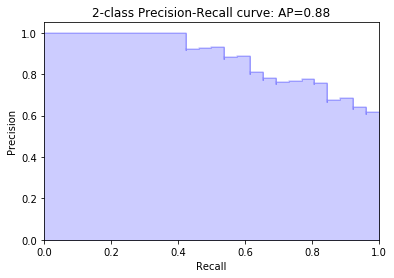

In [0]:
from sklearn.metrics import precision_recall_curve

import matplotlib.pyplot as plt
from inspect import signature

precision, recall, thresholds = precision_recall_curve(y_test, y_score)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

In [0]:
thresholds

array([-0.20078869, -0.18029058, -0.15043726, -0.14958466, -0.12733462,
       -0.1142941 , -0.09281931, -0.08794601, -0.08258102, -0.07007139,
       -0.06386267, -0.04914839, -0.04536122, -0.03991278,  0.0032915 ,
        0.01213433,  0.02619439,  0.03145977,  0.04871897,  0.0515638 ,
        0.06493837,  0.065023  ,  0.09898417,  0.11549516,  0.12179099,
        0.12585371,  0.16106135,  0.1906223 ,  0.20018683,  0.20105976,
        0.22408591,  0.22931596,  0.24693291,  0.26336904,  0.27523711,
        0.30423874,  0.31364573,  0.39424539,  0.40148935,  0.42411536,
        0.42593404,  0.49589616])

## Your turn

Try to generate ROC curves for your dataset and algorithm, and find a cutoff point with the best threshold. 

Even if your dataset is balanced, plot precision-recall curves as well.